## Part 1: Import Packages

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Part 2: Data Loading and Cleaning

In [2]:
customers_raw = pd.read_csv("BankChurners.csv")
transactions_raw = pd.read_csv("credit_card_transactions.csv")

In [3]:
#cleaning and renaming cols in customer df
customers = customers_raw.copy()
customers.columns = customers.columns.str.strip().str.lower()
nb_cols = [c for c in customers.columns if "naive_bayes" in c.lower()]
customers = customers.drop(columns=nb_cols, errors="ignore")
customers = customers.rename(columns={
    "clientnum": "customer_id",
    "attrition_flag": "attrition_flag",
    "customer_age": "age",
    "gender": "gender",
    "dependent_count": "dependents",
    "education_level": "education_level",
    "marital_status": "marital_status",
    "income_category": "income_category",
    "card_category": "card_category",
    "months_on_book": "months_on_book",
    "total_relationship_count": "num_relationships",
    "months_inactive_12_mon": "inactive_months_12",
    "contacts_count_12_mon": "contacts_12",
    "credit_limit": "credit_limit",
    "total_revolving_bal": "revolving_balance",
    "avg_open_to_buy": "avg_open_to_buy",
    "total_amt_chng_q4_q1": "amt_change_q4_q1",
    "total_trans_amt": "total_trans_amount",
    "total_trans_ct": "total_trans_count",
    "total_ct_chng_q4_q1": "count_change_q4_q1",
    "avg_utilization_ratio": "avg_utilization_ratio"
})

customers.head()

,customer_id,attrition_flag,age,gender,dependents,education_level,marital_status,income_category,card_category,months_on_book,...,inactive_months_12,contacts_12,credit_limit,revolving_balance,avg_open_to_buy,amt_change_q4_q1,total_trans_amount,total_trans_count,count_change_q4_q1,avg_utilization_ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
#cleaning and renaming cols in transactions
transactions = transactions_raw.copy()

#drop index column if present
if "Unnamed: 0" in transactions.columns:
    transactions = transactions.drop(columns=["Unnamed: 0"])

#standardizing column names
transactions.columns = transactions.columns.str.strip().str.lower()

#convert datetimes
transactions["trans_date_trans_time"] = pd.to_datetime(transactions["trans_date_trans_time"], errors="coerce")
transactions["dob"] = pd.to_datetime(transactions["dob"], errors="coerce")

#drop exact duplicates
transactions = transactions.drop_duplicates()

#standardize the text fields
for col in ["state", "category", "merchant", "city", "gender"]:
    transactions[col] = transactions[col].astype(str).str.strip()

#fill in missing merchant zipcode
transactions["merch_zipcode"] = transactions["merch_zipcode"].fillna(-1)

transactions.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,-1.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,-1.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [5]:
transactions.shape

(1296675, 23)

In [6]:
customers.shape

(10127, 21)

## Part 3: Creating SQL Database and Tables

In [7]:
conn = sqlite3.connect("credit_spending.db")

customers.to_sql("customers", conn, index=False, if_exists="replace")
transactions.to_sql("transactions", conn, index=False, if_exists="replace")

1296675

In [8]:
conn.execute("DROP TABLE IF EXISTS monthly_spending;")

conn.execute("""
CREATE TABLE monthly_spending AS
SELECT
    cc_num,
    strftime('%Y-%m', trans_date_trans_time) AS year_month,
    SUM(amt) AS total_spend,
    COUNT(*) AS num_transactions,
    AVG(amt) AS avg_transaction_amt
FROM transactions
GROUP BY cc_num, year_month;
""")

conn.commit()

monthly = pd.read_sql_query("SELECT * FROM monthly_spending;", conn)
monthly.head()

,cc_num,year_month,total_spend,num_transactions,avg_transaction_amt
0,60416207185,2019-01,2410.54,56,43.045357
1,60416207185,2019-02,2861.48,59,48.499661
2,60416207185,2019-03,6672.74,86,77.590000
3,60416207185,2019-04,6430.91,102,63.048137
4,60416207185,2019-05,3543.45,81,43.746296


In [9]:
#adding indexes for sql optimization
conn.execute("""
CREATE INDEX IF NOT EXISTS idx_transactions_cc_date
ON transactions (cc_num, trans_date_trans_time);
""")

conn.execute("""
CREATE INDEX IF NOT EXISTS idx_monthly_spending_cc_month
ON monthly_spending (cc_num, year_month);
""")

conn.commit()

In [10]:
monthly_sorted = monthly.sort_values(["cc_num", "year_month"])
monthly_sorted["next_month_spend"] = monthly_sorted.groupby("cc_num")["total_spend"].shift(-1)
monthly_sorted = monthly_sorted.dropna(subset=["next_month_spend"])
monthly_sorted["year_month"] = pd.to_datetime(monthly_sorted["year_month"])
monthly_sorted["month"] = monthly_sorted["year_month"].dt.month
monthly_sorted["quarter"] = monthly_sorted["year_month"].dt.quarter

## Part 4: Exploratory Data Analysis

In [11]:
import os

# Create folder for EDA plots
os.makedirs("eda_plots", exist_ok=True)

### Distribution of Total Monthy Spend

In [33]:
plt.figure(figsize=(6,4))
sns.histplot(monthly_sorted["total_spend"], bins=40, kde=True)
plt.title("Distribution of Monthly Total Spend")
plt.xlabel("Total Spend ($)")
plt.ylabel("Frequency")
plt.savefig("eda_plots/total_spend_distribution.png", dpi=100, bbox_inches='tight')
plt.close()

### Distribution of Number of Transactions

In [34]:
plt.figure(figsize=(6,4))
sns.histplot(monthly_sorted["num_transactions"], bins=40, kde=True, color='teal')
plt.title("Distribution of Number of Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Frequency")
plt.savefig("eda_plots/num_transactions_distribution.png", dpi=100, bbox_inches='tight')
plt.close()

### Average Transaction Amount Distribution

In [35]:
plt.figure(figsize=(6,4))
sns.histplot(monthly_sorted["avg_transaction_amt"], bins=40, kde=True, color="purple")
plt.title("Distribution of Average Transaction Amount")
plt.xlabel("Average Transaction Amount ($)")
plt.ylabel("Frequency")
plt.savefig("eda_plots/avg_transaction_amount_distribution.png", dpi=100, bbox_inches="tight")
plt.close()

### Average Monthly Spending Trend 

In [36]:
monthly_trend = monthly_sorted.groupby("year_month")["total_spend"].mean()

plt.figure(figsize=(6,4))
plt.plot(monthly_trend.index, monthly_trend.values)
plt.xticks(rotation=45)
plt.title("Average Monthly Spending Over Time")
plt.xlabel("Month")
plt.ylabel("Average Spend ($)")
plt.savefig("eda_plots/monthly_trend.png", dpi=100, bbox_inches="tight")
plt.close()

### Correlation Heatmap

In [37]:
plt.figure(figsize=(8,6))
corr = monthly_sorted[[
    "total_spend",
    "num_transactions",
    "avg_transaction_amt",
    "next_month_spend"
]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig("eda_plots/correlation_heatmap.png", dpi=100, bbox_inches="tight")
plt.close()  

### Scatter: Total Spend vs Number of Transactions

In [38]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=monthly_sorted["num_transactions"],
    y=monthly_sorted["total_spend"],
    alpha=0.4
)
plt.title("Total Spend vs Number of Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Total Spend ($)")
plt.savefig("eda_plots/total_spend_vs_num_transactions.png", dpi=100, bbox_inches="tight")
plt.close()

## Part 5: Model Preparation

### Creating Target Variables

In [18]:
X = monthly_sorted[[
    "total_spend",
    "num_transactions",
    "avg_transaction_amt",
    "month",
    "quarter"
]]
y = monthly_sorted["next_month_spend"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [19]:
def evaluate(model):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return rmse, mae, r2

### Linear Regression

In [20]:
lr = LinearRegression().fit(X_train, y_train)
lr_results = evaluate(lr)

### KNN

In [21]:
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
knn_results = evaluate(knn)

### Decision Tree

In [22]:
dt = DecisionTreeRegressor(max_depth=6, random_state=42).fit(X_train, y_train)
dt_results = evaluate(dt)

### Random Forest

In [23]:
rf = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_train, y_train)
rf_results = evaluate(rf)

### Gradient Boosting

In [24]:
gbr = GradientBoostingRegressor(
    n_estimators=400, learning_rate=0.03, max_depth=3, subsample=0.9
).fit(X_train, y_train)
gbr_results = evaluate(gbr)

## Part 5: Model Comparison Table + Determination

In [25]:
results = pd.DataFrame({
    "Model": ["Linear Regression","KNN","Decision Tree","Random Forest","Gradient Boosting"],
    "RMSE": [lr_results[0], knn_results[0], dt_results[0], rf_results[0], gbr_results[0]],
    "MAE": [lr_results[1], knn_results[1], dt_results[1], rf_results[1], gbr_results[1]],
    "R²": [lr_results[2], knn_results[2], dt_results[2], rf_results[2], gbr_results[2]],
})
results

,Model,RMSE,MAE,R²
0,Linear Regression,3154.789743,2129.091698,0.409197
1,KNN,2411.701940,1597.542170,0.654738
2,Decision Tree,2257.804401,1578.420516,0.697396
3,Random Forest,2250.295138,1548.176273,0.699406
4,Gradient Boosting,2129.545402,1458.206911,0.730800


The **Gradient Boosting Model** performs the best!!

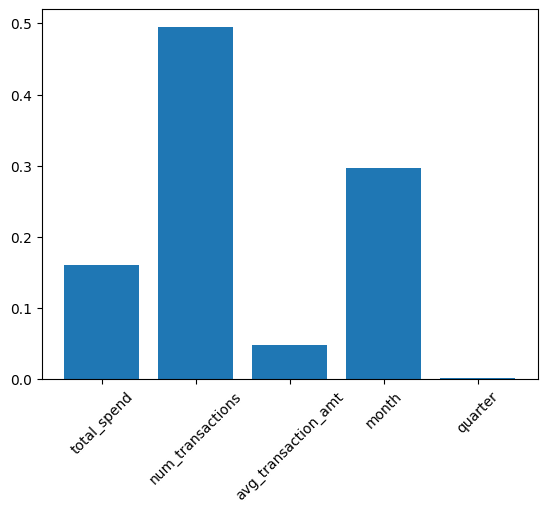

In [26]:
plt.bar(X.columns, gbr.feature_importances_)
plt.xticks(rotation=45)
plt.show()

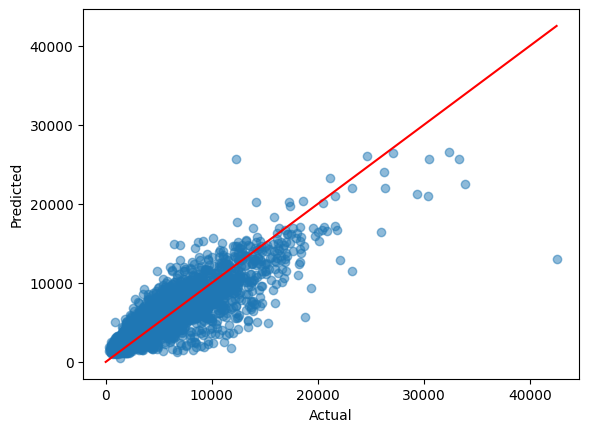

In [27]:
pred = gbr.predict(X_test)

plt.scatter(y_test, pred, alpha=0.5)
plt.plot([0,max(y_test)], [0,max(y_test)], color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### Creating Residual Plot

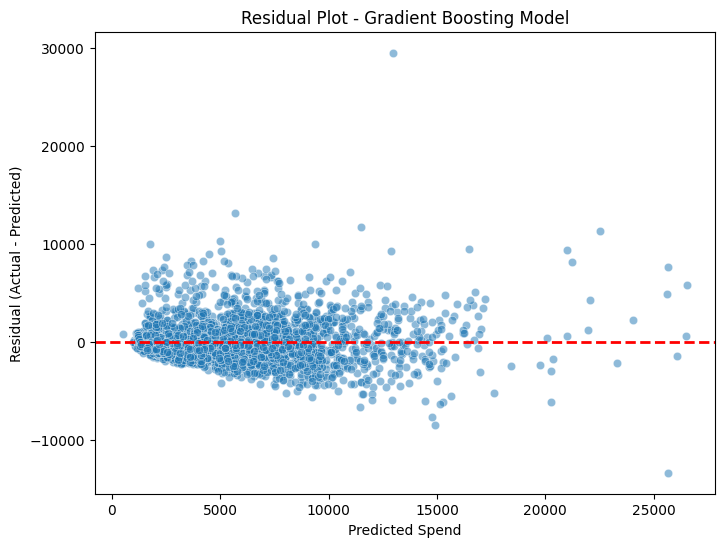

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

gbr_pred = gbr.predict(X_test)
residuals = y_test - gbr_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=gbr_pred, y=residuals, alpha=0.5)

# Add horizontal line at 0
plt.axhline(0, color='red', linestyle='--', linewidth=2)

plt.xlabel("Predicted Spend")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot - Gradient Boosting Model")

plt.show()
